In [2]:
#basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hr, day, MW
import sys

# osier imports
from osier import DispatchModel
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination

# automatically set the solver
if "darwin" in sys.platform:
    solver = 'cplex_direct'
print(f"Solver set: {solver}")

Solver set: cplex_direct


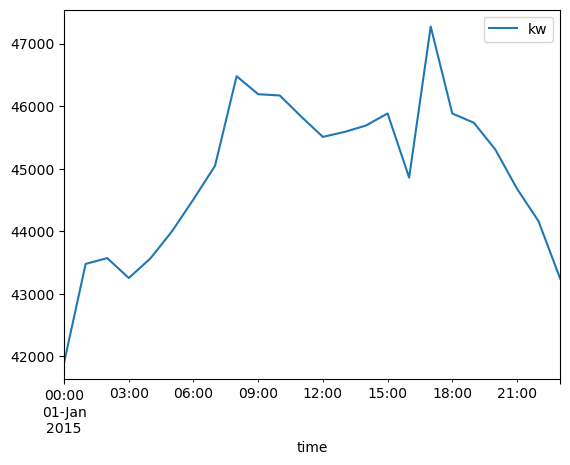

In [4]:
#importing actual UIUC demand data
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/uiuc_demand_data.csv"
demand_data = pd.read_csv(url, usecols=['time', 'kw'], parse_dates=True,index_col='time')
dem_vals = demand_data.loc['2015-01-01']
dem_vals.plot();plt.show()

#establishing demand data for running in the simulation
demand = dem_vals['kw'].values

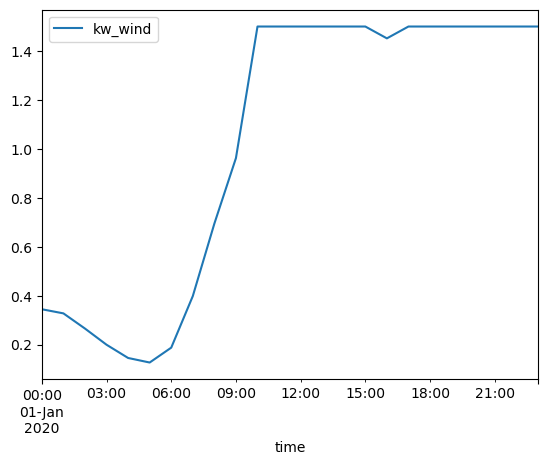

In [5]:
#importing wind data
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/nsrdb_data/windHistory_2020.csv"
wind_power_data = pd.read_csv(url, usecols=['time', 'kw_wind'], parse_dates=True,index_col='time')
wind_power = wind_power_data.loc['2020-01-01']#'2020-01-02']
#wind_power2 = wind_power_data.loc['2020-01-02']
wind_power.plot();plt.show()

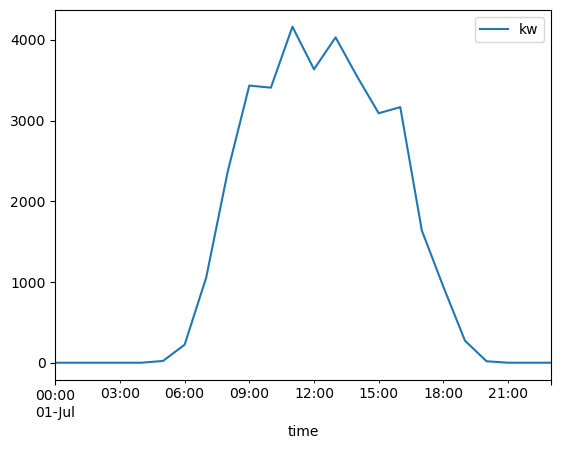

In [6]:
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/solarfarm_data.csv"
solar_power = pd.read_csv(url, usecols=['time', 'kw'], parse_dates=True, index_col='time')

# choose a single day
solar_day = solar_power.loc['2016-07-01']
solar_day.plot();plt.show()

In [7]:
#getting the energy production values to run in the model

#solar power
solar_day_ener = solar_day['kw'].values
df_solar = pd.DataFrame(solar_day_ener, columns=['Energy'])
solar_ener = df_solar['Energy'].values

#wind power
wind_ener = wind_power['kw_wind'].values

In [8]:
#creating energy mix

#based off osier documentation, we need to include geothermal and add the capacity for coal
#adding capacity of coal, based on research
from osier.tech_library import coal

#finally, create the necessary energy mix
UIUC_mix = [lib.natural_gas,lib.coal,lib.solar,lib.wind]
display(UIUC_mix)

[NaturalGas_Conv: 8375.1331 MW,
 Coal_Conv: 0.0 MW,
 SolarPanel: 2810.3015 MW,
 WindTurbine: 0.0 MW]

In [9]:
#now wanting to do a multi-objective run
#considered total cost, lets consider limitng CO2 emissions
from osier import annual_emission, total_cost
problem2 = CapacityExpansion(technology_list = UIUC_mix,
                            demand=demand*MW,
                            solar=solar_ener,
                            wind=wind_ener,
                            upper_bound= 1 / lib.solar.capacity_credit,
                            objectives = [total_cost,annual_emission],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [30]:
algorithm = NSGA2(pop_size=20)
termination = RobustTermination(MultiObjectiveSpaceTermination(tol=0.015, n_skip=1), period=10)
import time
start = time.perf_counter()
res = minimize(problem2,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      3 |             - |             -
     2 |       40 |      5 |  0.1068991586 |         ideal
     3 |       60 |      8 |  0.0183011975 |         ideal
     4 |       80 |      8 |  0.0626398526 |         ideal
     5 |      100 |     14 |  0.1598495445 |         ideal
     6 |      120 |     17 |  0.0673166656 |         ideal
     7 |      140 |     18 |  0.0073758602 |         ideal
     8 |      160 |     20 |  0.0326493137 |         ideal
     9 |      180 |     20 |  0.0036074878 |         ideal
    10 |      200 |     19 |  0.0245320245 |         ideal
    11 |      220 |     20 |  0.0107781369 |         ideal
    12 |      240 |     20 |  0.0066764892 |             f
    13 |      260 |     20 |  0.0184305355 |         ideal
    14 |      280 |     20 |  0.0154060662 |             f
    15 |      300 |     20 |  0.0054701054 |             f
    16 |      320 |     20 |  0.0091834826 |            

In [31]:
#displaying multi-objective results
display(res.F),display(res.X)

array([[2.23099332e+04, 8.12242620e-02],
       [2.40812944e+03, 5.22444022e-01],
       [1.48091225e+04, 9.92783901e-02],
       [3.18292009e+03, 4.35221623e-01],
       [7.98407218e+03, 1.48121986e-01],
       [6.07489487e+03, 1.70064914e-01],
       [5.50506449e+03, 1.90398681e-01],
       [1.69943959e+04, 8.97610567e-02],
       [2.04449256e+04, 8.23095624e-02],
       [5.06170203e+03, 2.44707469e-01],
       [3.72650906e+03, 3.68298244e-01],
       [1.83923586e+04, 8.52408859e-02],
       [1.30948919e+04, 1.10379756e-01],
       [4.39306282e+03, 3.04449746e-01],
       [4.04218786e+03, 3.38230780e-01],
       [1.05267334e+04, 1.24768363e-01],
       [3.10435422e+03, 4.57835452e-01],
       [3.05106857e+03, 4.87885631e-01],
       [2.59309680e+03, 4.96261134e-01],
       [4.73463759e+03, 2.76777713e-01]])

array([[9.95754823e-01, 4.10183742e-05, 2.42273406e-05, 5.25974907e+00],
       [9.76996404e-01, 4.26912892e-03, 2.70955658e-02, 8.84427930e-03],
       [8.61005573e-01, 3.58181706e-04, 3.32415116e-02, 3.35257146e+00],
       [9.25465742e-01, 4.41233388e-03, 2.94574587e-03, 2.56109940e-01],
       [9.76996404e-01, 8.12931272e-04, 2.76889421e-01, 1.37649545e+00],
       [9.12701809e-01, 1.09437927e-03, 2.73650880e-01, 9.14258323e-01],
       [8.67778383e-01, 1.09978559e-03, 4.07868582e-02, 8.93033510e-01],
       [9.96573640e-01, 4.10628808e-05, 7.39545234e-04, 3.85897400e+00],
       [5.83977586e-01, 1.07817483e-03, 2.24993904e-03, 5.02072252e+00],
       [9.11868995e-01, 1.10012552e-03, 3.51576015e-03, 7.64630083e-01],
       [9.08078367e-01, 1.49689224e-06, 2.90774521e-01, 2.89915466e-01],
       [5.72389783e-01, 4.09385568e-05, 2.61762802e-02, 4.47791854e+00],
       [9.77007730e-01, 4.67087118e-05, 2.70955658e-02, 2.83238330e+00],
       [9.12701809e-01, 1.32831931e-04, 2.73650880e

(None, None)

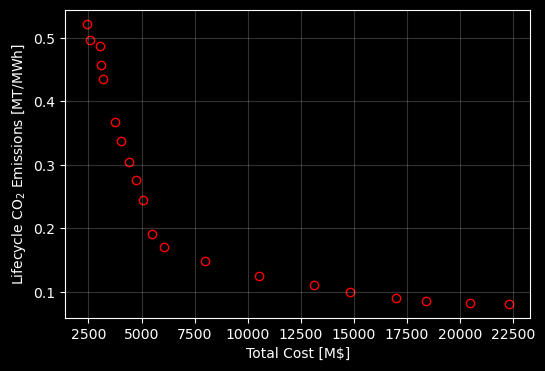

In [32]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()